# 07 - Climate-Driven Morphology

This notebook demonstrates how physics-based environmental modeling creates principled
reasons for morphological diversity in trees. The upgraded physics (orientation-based 
wind exposure, Gaussian splat self-shading) produces distinct tree forms from identical
growth rules under different environmental conditions.

**Core thesis**: Tree morphology emerges from environmental physics, not hand-crafted rules.

Key demonstrations:
1. **Wind direction affects exposure**: Branches perpendicular to wind experience greater force
2. **Self-shading creates canopy spread**: Dense clustering is penalized by light competition
3. **Resource gradients bias form**: Trees lean toward water and nutrients
4. **Climate determines morphology**: The spectrum from vigorous growth to stress-adapted forms

In [1]:
import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.collections import LineCollection
import numpy as np

from sim.skeleton import (
    SkeletonState,
    SoilTiles,
    compute_segment_positions_2d,
    compute_light_capture,
    compute_wind_exposure,
    compute_root_uptake,
    get_tip_indices,
)

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 10)
plt.rcParams['font.size'] = 11

## 1. Helper Functions for Visualization

In [2]:
def create_tree(growth: float = 1.0, asymmetry: float = 0.0, depth: int = 4) -> SkeletonState:
    """
    Create a tree skeleton with specified growth and asymmetry.
    
    Args:
        growth: Overall growth factor (0-1)
        asymmetry: Bias toward right (+) or left (-) side
        depth: Tree depth (4 = 15 segments)
    """
    num_segments = 2**depth - 1
    tip_indices = get_tip_indices(depth)
    
    # Base structure that decreases with level
    length = jnp.zeros(num_segments)
    thickness = jnp.zeros(num_segments)
    alive = jnp.zeros(num_segments)
    angle = jnp.zeros(num_segments)
    leaf_area = jnp.zeros(num_segments)
    flower_area = jnp.zeros(num_segments)
    
    # Trunk is always vertical
    angle = angle.at[0].set(jnp.pi / 2)
    
    for idx in range(num_segments):
        level = int(np.floor(np.log2(idx + 1)))
        depth_factor = 1.0 - 0.15 * level
        
        # Asymmetry: left branches (odd indices at each level) grow differently
        if idx > 0:
            is_left = (idx % 2 == 1)
            side_factor = 1.0 + asymmetry * (0.3 if is_left else -0.3)
        else:
            side_factor = 1.0
        
        # Length and thickness
        base_length = 0.35 * depth_factor * side_factor
        length = length.at[idx].set(base_length * growth)
        
        base_thickness = 0.25 * (depth_factor ** 1.5)
        thickness = thickness.at[idx].set(base_thickness * growth)
        
        # Alive probability decreases with depth and stress
        alive_prob = min(1.0, growth * depth_factor * side_factor)
        alive = alive.at[idx].set(max(0.0, alive_prob))
        
        # Branch angles
        if idx > 0:
            is_left = (idx % 2 == 1)
            spread = jnp.pi / 4 / (level + 1)
            # Asymmetry affects spread
            spread_adj = spread * (1 + asymmetry * 0.2 * (1 if is_left else -1))
            angle = angle.at[idx].set(spread_adj if is_left else -spread_adj)
    
    # Leaves at tips, affected by asymmetry
    for i, tip_idx in enumerate(tip_indices):
        tip_idx = int(tip_idx)
        # Left tips (first half) vs right tips (second half)
        is_left_side = i < len(tip_indices) // 2
        side_mult = 1.0 + asymmetry * (0.4 if is_left_side else -0.4)
        leaf_amount = 0.4 * growth * max(0.1, side_mult)
        leaf_area = leaf_area.at[tip_idx].set(leaf_amount)
        
        # Flowers appear late in growth
        if growth > 0.7:
            flower_amount = (growth - 0.7) / 0.3 * 0.2 * side_mult
            flower_area = flower_area.at[tip_idx].set(max(0, flower_amount))
    
    return SkeletonState(
        length=length,
        thickness=thickness,
        alive=alive,
        angle=angle,
        leaf_area=leaf_area,
        flower_area=flower_area,
    )


def draw_tree(
    skeleton: SkeletonState,
    ax=None,
    color_by: str = "alive",  # "alive", "wind", "light"
    wind_speed: float = 0.0,
    wind_direction: float = 0.0,
    soil: SoilTiles = None,
    title: str = "",
    show_metrics: bool = True,
):
    """
    Draw tree with physics-based coloring.
    """
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    
    x, y, abs_angles = compute_segment_positions_2d(skeleton)
    x, y = np.array(x), np.array(y)
    abs_angles = np.array(abs_angles)
    
    tip_indices = get_tip_indices(skeleton.depth)
    
    # Compute physics if needed
    if color_by == "wind":
        exposure = compute_wind_exposure(skeleton, wind_speed, wind_direction)
        exposure = np.array(exposure)
        max_exp = np.max(exposure) + 0.001
    elif color_by == "light":
        light = compute_light_capture(skeleton)
        light = np.array(light)
        max_light = np.max(light) + 0.001
    
    # Draw soil tiles if provided
    if soil is not None:
        tile_colors = ['#5D8AA8', '#8B7355', '#228B22']  # water-rich, normal, nutrient-rich
        tile_width = 3.0 / soil.num_tiles
        for i in range(soil.num_tiles):
            x_start = -1.5 + i * tile_width
            # Color intensity based on water content
            water = float(soil.water[i])
            alpha = 0.3 + 0.4 * water
            rect = mpatches.Rectangle(
                (x_start, -0.4), tile_width, 0.4,
                facecolor=tile_colors[i],
                edgecolor='#1a1a1a',
                linewidth=2,
                alpha=alpha,
            )
            ax.add_patch(rect)
            # Label with water/nutrient values
            ax.text(x_start + tile_width/2, -0.35, 
                   f'W:{water:.1f}\nN:{float(soil.nutrients[i]):.1f}',
                   ha='center', va='top', fontsize=8, color='white')
    else:
        # Default ground
        ax.fill_between([-1.5, 1.5], -0.4, 0, color='#8B7355', alpha=0.3)
    
    ax.axhline(0, color='#654321', linewidth=3, alpha=0.7)
    
    # Draw wind arrow if wind is present
    if wind_speed > 0.1:
        wind_x = 1.3 * np.cos(wind_direction)
        wind_y = 1.3 * np.sin(wind_direction)
        ax.annotate('', xy=(0.0, 1.5), xytext=(wind_x, 1.5 + wind_y * 0.3),
                   arrowprops=dict(arrowstyle='->', color='#4A90A4', lw=3))
        ax.text(wind_x * 0.7, 1.7, f'Wind {wind_speed:.1f}', 
               fontsize=10, color='#4A90A4', ha='center')
    
    # Draw branches
    for idx in range(skeleton.num_segments):
        alive = float(skeleton.alive[idx])
        if alive < 0.1:
            continue
        
        if idx == 0:
            start_x, start_y = 0.0, 0.0
        else:
            parent = (idx - 1) // 2
            start_x, start_y = x[parent], y[parent]
        
        end_x, end_y = x[idx], y[idx]
        
        thickness = float(skeleton.thickness[idx])
        linewidth = 2 + 10 * thickness * alive
        
        # Color based on selected metric
        if color_by == "wind":
            exp_frac = exposure[idx] / max_exp
            red = int(139 + 116 * exp_frac)
            green = int(69 * (1 - exp_frac * 0.8))
            blue = int(19 * (1 - exp_frac))
            color = f'#{red:02x}{green:02x}{blue:02x}'
        else:
            color = '#8B4513'  # Default brown
        
        ax.plot([start_x, end_x], [start_y, end_y], 
                color=color, linewidth=linewidth, 
                solid_capstyle='round', alpha=0.3 + 0.7*alive)
    
    # Draw leaves at tips
    leaf_colors = ['#C0392B', '#E74C3C', '#27AE60', '#2ECC71', '#F39C12', '#E67E22', '#9B59B6', '#3498DB']
    
    for i, tip_idx in enumerate(tip_indices):
        tip_idx = int(tip_idx)
        leaf_area_val = float(skeleton.leaf_area[tip_idx])
        alive = float(skeleton.alive[tip_idx])
        
        if leaf_area_val * alive < 0.01:
            continue
        
        leaf_size = 0.1 + 0.25 * np.sqrt(leaf_area_val * alive)
        
        # Color by light capture if that's the mode
        if color_by == "light":
            light_frac = light[tip_idx] / max_light
            green = int(100 + 155 * light_frac)
            color = f'#{30:02x}{green:02x}{30:02x}'
        else:
            color = leaf_colors[i % len(leaf_colors)]
        
        # Leaf angle based on branch
        angle = np.degrees(abs_angles[tip_idx]) - 90
        
        ellipse = mpatches.Ellipse(
            (x[tip_idx], y[tip_idx]),
            width=leaf_size * 0.5,
            height=leaf_size,
            angle=angle,
            facecolor=color,
            edgecolor='#1a1a1a',
            linewidth=1.5,
            alpha=0.85,
        )
        ax.add_patch(ellipse)
        
        # Draw flowers
        flower_area_val = float(skeleton.flower_area[tip_idx])
        if flower_area_val * alive > 0.01:
            flower_size = 0.03 + 0.08 * np.sqrt(flower_area_val * alive)
            circle = mpatches.Circle(
                (x[tip_idx] + 0.05, y[tip_idx] + 0.05),
                radius=flower_size,
                facecolor='#FF6B6B',
                edgecolor='#C0392B',
                linewidth=1,
                alpha=0.9,
            )
            ax.add_patch(circle)
    
    # Metrics box
    if show_metrics:
        total_light = float(jnp.sum(compute_light_capture(skeleton)))
        total_wind = float(jnp.sum(compute_wind_exposure(skeleton, wind_speed, wind_direction)))
        metrics_text = f'Light: {total_light:.2f}\nWind exp: {total_wind:.2f}'
        ax.text(1.4, 2.3, metrics_text, fontsize=9, ha='right', va='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.set_xlim(-1.5, 1.5)
    ax.set_ylim(-0.5, 2.5)
    ax.set_aspect('equal')
    ax.axis('off')
    
    if title:
        ax.set_title(title, fontsize=12, fontweight='bold')
    
    return ax

## 2. Wind Direction and Exposure

Wind direction affects branch exposure through projected area physics:
branches oriented perpendicular to wind direction experience maximum drag force.

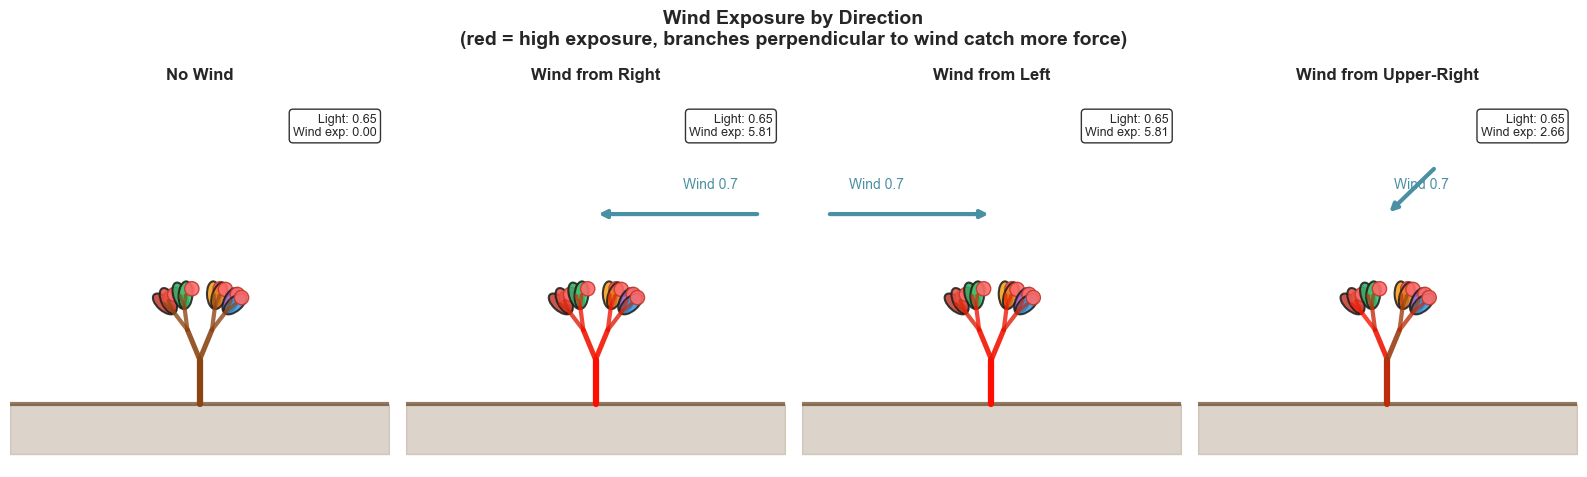

In [3]:
# Create a symmetric tree
tree = create_tree(growth=1.0, asymmetry=0.0)

# Show wind from different directions
fig, axes = plt.subplots(1, 4, figsize=(16, 5))

wind_directions = [
    (0.0, 'No Wind'),
    (0.0, 'Wind from Right'),
    (np.pi, 'Wind from Left'),
    (np.pi/2 - 0.3, 'Wind from Upper-Right'),
]
wind_speeds = [0.0, 0.7, 0.7, 0.7]

for ax, (direction, title), speed in zip(axes, wind_directions, wind_speeds):
    draw_tree(tree, ax=ax, color_by='wind', 
             wind_speed=speed, wind_direction=direction,
             title=title)

plt.suptitle('Wind Exposure by Direction\n(red = high exposure, branches perpendicular to wind catch more force)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3. Self-Shading and Light Competition

The Gaussian splat shading model creates genuine competition for light resources.
Leaves positioned below others receive reduced illumination, with the effect
attenuated by horizontal displacement.

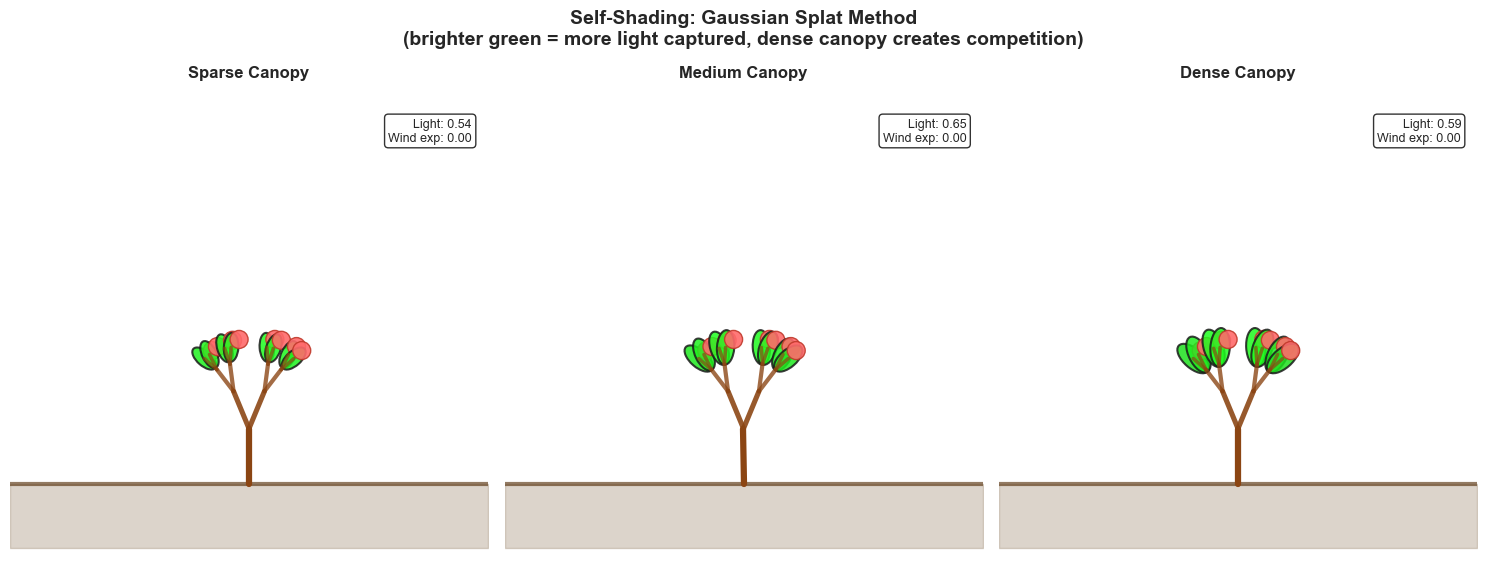

In [4]:
# Create trees with different canopy densities
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Sparse, medium, dense canopy
for ax, density, title in zip(axes, [0.5, 1.0, 1.5], ['Sparse Canopy', 'Medium Canopy', 'Dense Canopy']):
    # Create tree and scale leaf area
    tree = create_tree(growth=1.0, asymmetry=0.0)
    scaled_leaves = tree.leaf_area * density
    dense_tree = SkeletonState(
        length=tree.length,
        thickness=tree.thickness,
        alive=tree.alive,
        angle=tree.angle,
        leaf_area=scaled_leaves,
        flower_area=tree.flower_area,
    )
    
    draw_tree(dense_tree, ax=ax, color_by='light', title=title)

plt.suptitle('Self-Shading: Gaussian Splat Method\n(brighter green = more light captured, dense canopy creates competition)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 4. Resource Gradients and Directional Growth

When soil resources are distributed asymmetrically, trees exhibit directional bias
in their growth patterns, allocating more biomass toward resource-rich regions.

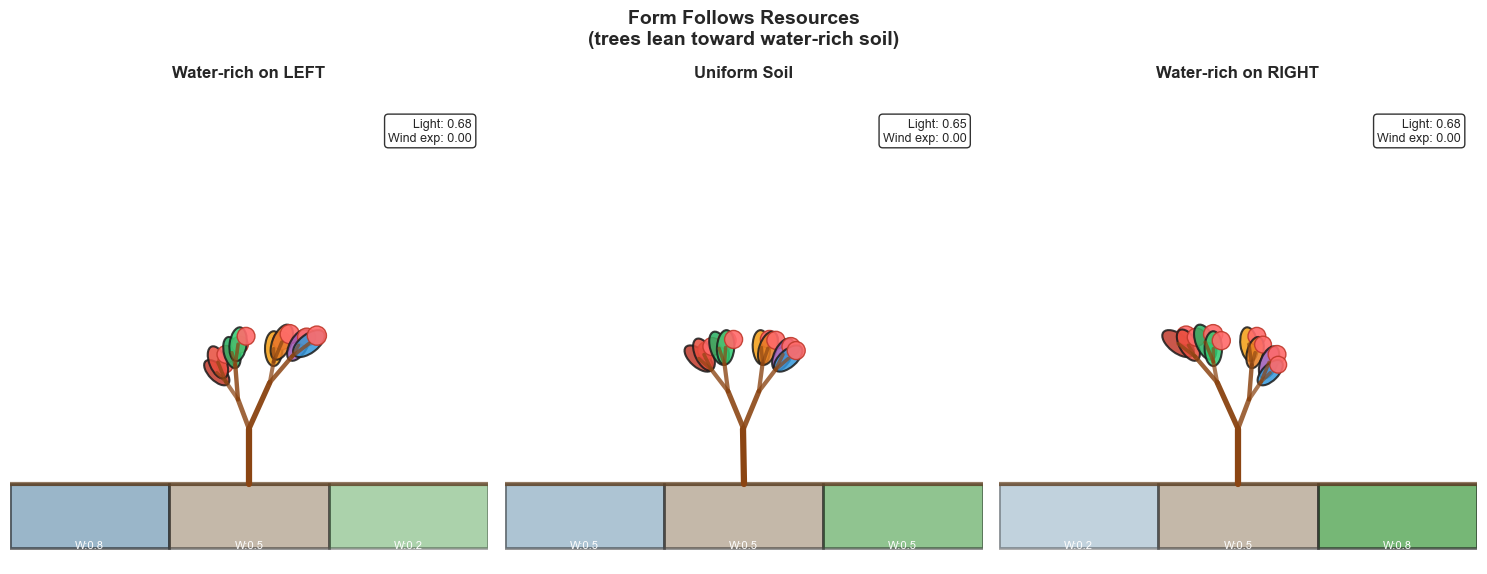

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 6))

# Create soils with different gradients
soils = [
    (SoilTiles.asymmetric(water_gradient=-0.3), -0.4, 'Water-rich on LEFT'),
    (SoilTiles.default(), 0.0, 'Uniform Soil'),
    (SoilTiles.asymmetric(water_gradient=0.3), 0.4, 'Water-rich on RIGHT'),
]

for ax, (soil, asymmetry, title) in zip(axes, soils):
    # Tree leans toward the water
    tree = create_tree(growth=1.0, asymmetry=asymmetry)
    draw_tree(tree, ax=ax, soil=soil, title=title)

plt.suptitle('Form Follows Resources\n(trees lean toward water-rich soil)', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 5. Emergent Morphological Adaptation

**Same growth model, different environments → visibly different trees.**

This demonstrates the central result: morphology emerges from physics rather than 
being explicitly programmed. Environmental pressures create selective advantages 
for certain forms, and these advantages manifest as visible structural differences.

In [6]:
def create_climate_adapted_tree(
    wind_exposure: float = 0.0,  # 0 = calm, 1 = very windy
    light_competition: float = 0.0,  # 0 = full sun, 1 = forest understory
    water_stress: float = 0.0,  # 0 = wet, 1 = drought
    soil_asymmetry: float = 0.0,  # -1 to 1, bias toward resources
) -> SkeletonState:
    """
    Create a tree morphology adapted to environmental conditions.
    
    These are the kinds of adaptations a learned policy should discover:
    - High wind → thicker trunk, lower profile, denser wood
    - Light competition → taller, sparser, reaching for canopy gaps
    - Drought → deeper roots, smaller leaves, more conservative
    - Asymmetric soil → lean toward resources
    """
    depth = 4
    num_segments = 2**depth - 1
    tip_indices = get_tip_indices(depth)
    
    # Base growth reduced by stress
    base_growth = 1.0 - 0.3 * water_stress
    
    # Wind adaptation: shorter, thicker, lower spread
    wind_length_mult = 1.0 - 0.4 * wind_exposure  # Shorter in wind
    wind_thickness_mult = 1.0 + 0.5 * wind_exposure  # Thicker in wind
    wind_spread_mult = 1.0 - 0.3 * wind_exposure  # Tighter angles in wind
    
    # Light competition: taller, reaching upward
    light_length_mult = 1.0 + 0.3 * light_competition
    light_spread_mult = 1.0 - 0.2 * light_competition  # More vertical in shade
    
    # Build skeleton
    length = jnp.zeros(num_segments)
    thickness = jnp.zeros(num_segments)
    alive = jnp.zeros(num_segments)
    angle = jnp.zeros(num_segments)
    leaf_area = jnp.zeros(num_segments)
    flower_area = jnp.zeros(num_segments)
    
    # Trunk
    angle = angle.at[0].set(jnp.pi / 2 + soil_asymmetry * 0.1)  # Slight lean toward resources
    length = length.at[0].set(0.4 * base_growth * wind_length_mult * light_length_mult)
    thickness = thickness.at[0].set(0.3 * wind_thickness_mult)
    alive = alive.at[0].set(1.0)
    
    for idx in range(1, num_segments):
        level = int(np.floor(np.log2(idx + 1)))
        depth_factor = 1.0 - 0.15 * level
        
        # Side factor for asymmetry
        is_left = (idx % 2 == 1)
        side_factor = 1.0 + soil_asymmetry * (0.3 if is_left else -0.3)
        
        # Length
        base_len = 0.3 * depth_factor * base_growth * wind_length_mult * light_length_mult
        length = length.at[idx].set(base_len * side_factor)
        
        # Thickness
        base_thick = 0.2 * (depth_factor ** 1.5) * wind_thickness_mult
        thickness = thickness.at[idx].set(base_thick)
        
        # Alive
        alive_prob = min(1.0, base_growth * depth_factor * side_factor)
        # Wind kills exposed tips
        if level >= 3 and wind_exposure > 0.5:
            alive_prob *= 0.7
        alive = alive.at[idx].set(max(0.0, alive_prob))
        
        # Angles - tighter in wind, reaching up in shade
        base_spread = jnp.pi / 4 / (level + 1)
        spread = base_spread * wind_spread_mult * light_spread_mult
        # Add asymmetric bias
        spread_adj = spread * (1 + soil_asymmetry * 0.2 * (1 if is_left else -1))
        angle = angle.at[idx].set(spread_adj if is_left else -spread_adj)
    
    # Leaves - smaller in drought, concentrated at top in shade
    for i, tip_idx in enumerate(tip_indices):
        tip_idx = int(tip_idx)
        is_left_side = i < len(tip_indices) // 2
        side_mult = 1.0 + soil_asymmetry * (0.4 if is_left_side else -0.4)
        
        # Drought reduces leaf size
        drought_mult = 1.0 - 0.5 * water_stress
        # Light competition favors top leaves
        position_bonus = 1.0 + light_competition * 0.3 * (i / len(tip_indices) - 0.5)
        
        leaf_amount = 0.35 * base_growth * drought_mult * max(0.1, side_mult) * max(0.5, position_bonus)
        leaf_area = leaf_area.at[tip_idx].set(leaf_amount)
        
        # Flowers
        if base_growth > 0.6:
            flower_amount = (base_growth - 0.6) / 0.4 * 0.15 * max(0.1, side_mult)
            flower_area = flower_area.at[tip_idx].set(max(0, flower_amount))
    
    return SkeletonState(
        length=length,
        thickness=thickness,
        alive=alive,
        angle=angle,
        leaf_area=leaf_area,
        flower_area=flower_area,
    )

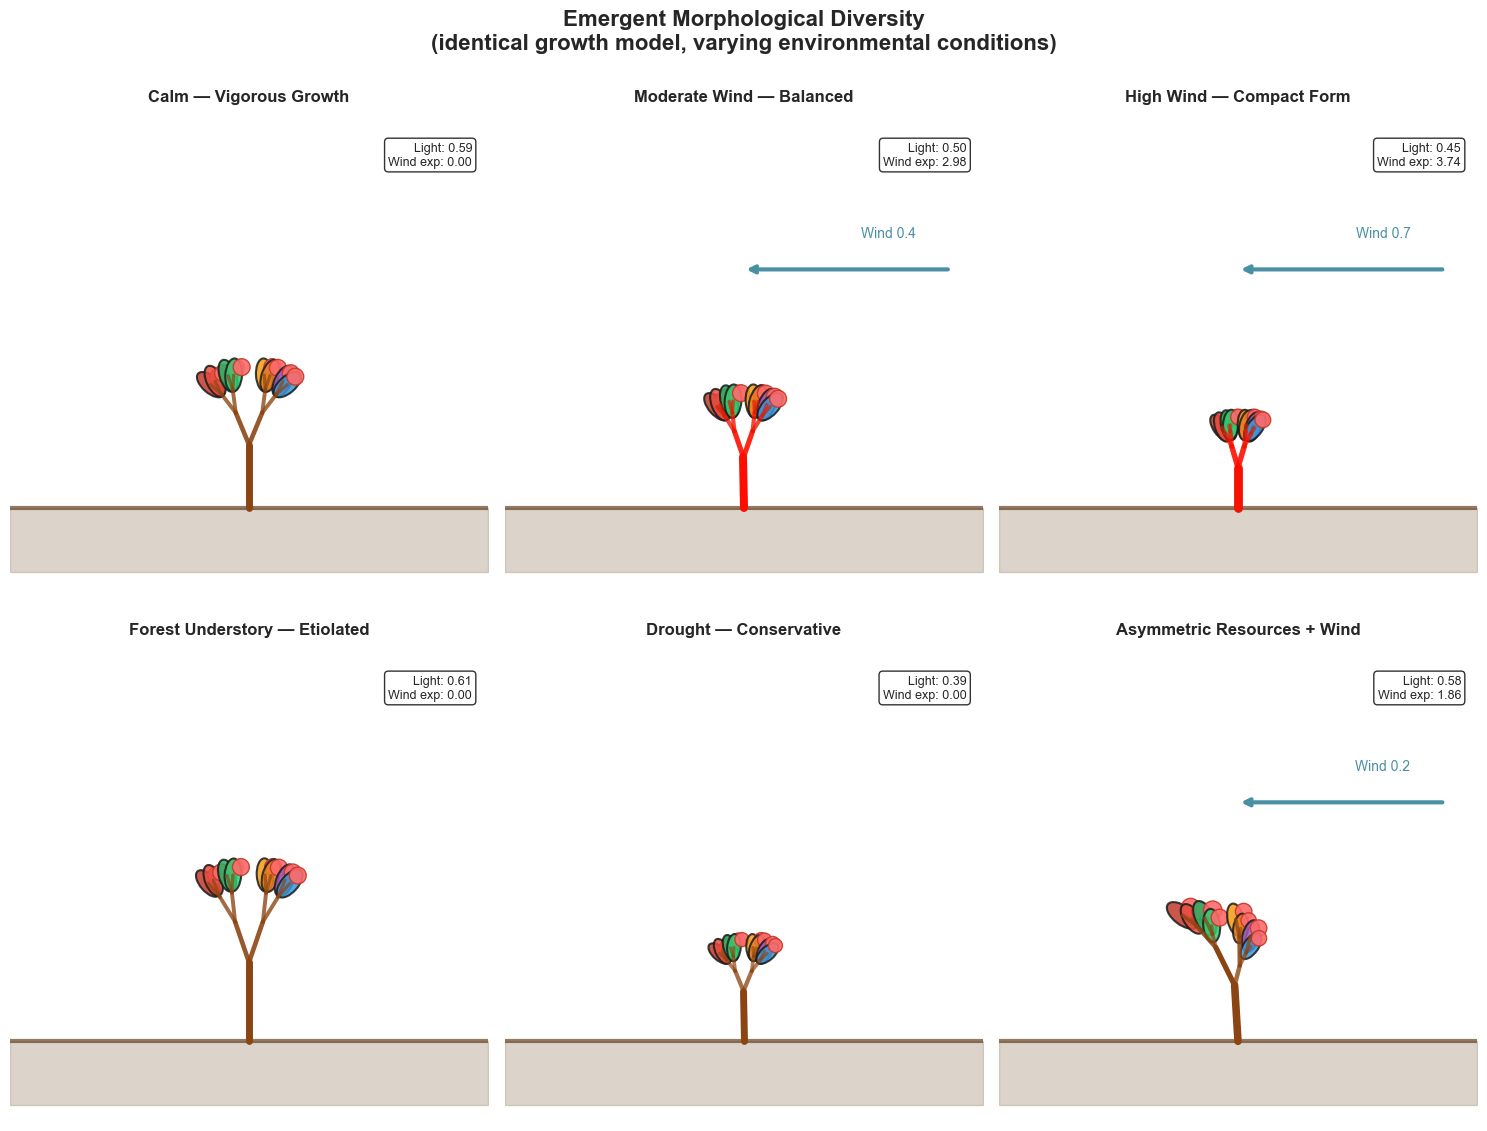

In [7]:
# Demonstrate how different climates produce different morphologies
fig, axes = plt.subplots(2, 3, figsize=(15, 12))

climates = [
    # Row 1: Wind gradient
    {'wind_exposure': 0.0, 'title': 'Calm — Vigorous Growth'},
    {'wind_exposure': 0.5, 'title': 'Moderate Wind — Balanced'},
    {'wind_exposure': 0.9, 'title': 'High Wind — Compact Form'},
    # Row 2: Other stresses
    {'light_competition': 0.8, 'title': 'Forest Understory — Etiolated'},
    {'water_stress': 0.7, 'title': 'Drought — Conservative'},
    {'soil_asymmetry': 0.6, 'wind_exposure': 0.3, 'title': 'Asymmetric Resources + Wind'},
]

for ax, climate in zip(axes.flat, climates):
    title = climate.pop('title')
    tree = create_climate_adapted_tree(**climate)
    
    # Use wind coloring for wind-stressed trees
    wind_exp = climate.get('wind_exposure', 0.0)
    color_by = 'wind' if wind_exp > 0.3 else 'alive'
    
    draw_tree(tree, ax=ax, color_by=color_by,
             wind_speed=wind_exp * 0.8, wind_direction=0.0,
             title=title)

plt.suptitle('Emergent Morphological Diversity\n'
             '(identical growth model, varying environmental conditions)',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

## 6. The Stress-Adaptation Continuum

Environmental stress exists on a continuum from benign to severe. This visualization
shows how morphology changes progressively as combined stressors increase.

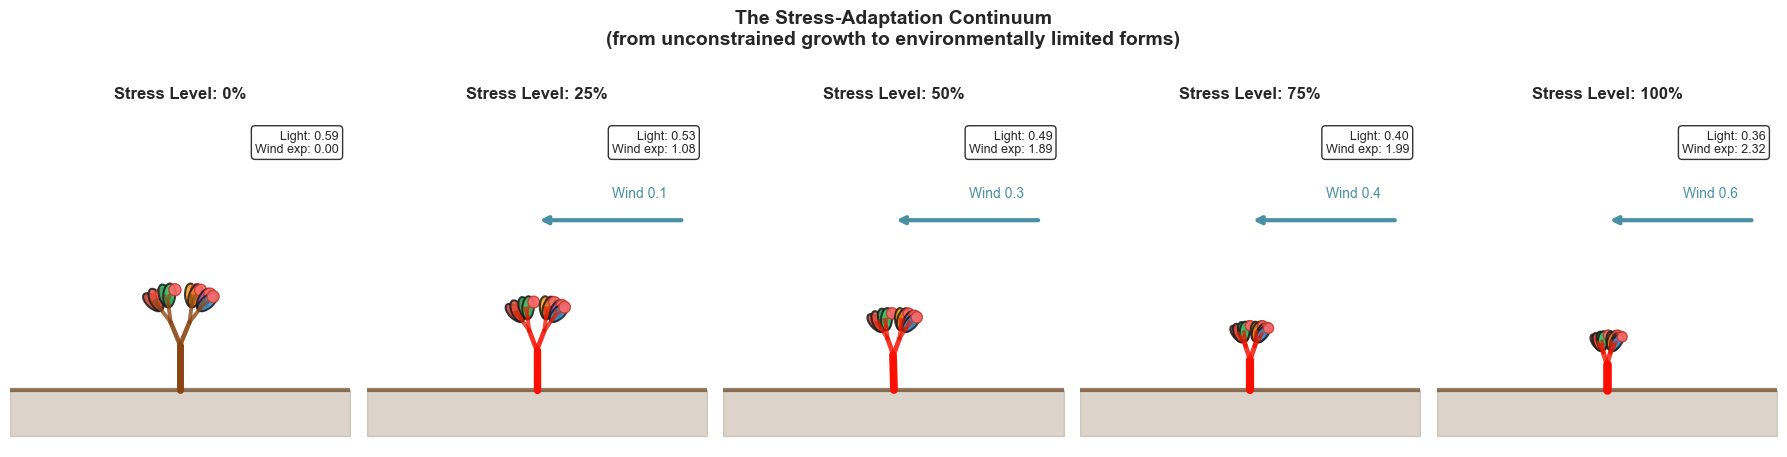

In [8]:
# Show a gradient from minimal to maximal environmental stress
fig, axes = plt.subplots(1, 5, figsize=(18, 5))

stress_levels = [0.0, 0.25, 0.5, 0.75, 1.0]

for ax, stress in zip(axes, stress_levels):
    tree = create_climate_adapted_tree(
        wind_exposure=stress * 0.8,
        water_stress=stress * 0.5,
        light_competition=0.0,
    )
    draw_tree(tree, ax=ax, color_by='wind', 
             wind_speed=stress * 0.6, wind_direction=0.0,
             title=f'Stress Level: {stress:.0%}')

plt.suptitle('The Stress-Adaptation Continuum\n'
             '(from unconstrained growth to environmentally limited forms)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 7. Discussion

The physics-based approach creates **principled reasons for morphological diversity**:

1. **Wind direction and branch orientation** → branches parallel to prevailing wind experience reduced drag
2. **Gaussian self-shading** → spreading canopies capture more light than dense clusters
3. **Soil resource tiles** → asymmetric allocation biases growth toward available resources
4. **Combined environmental stresses** → complex, realistic adaptive responses

**Key insight**: The model does not explicitly encode rules like "grow shorter in wind" or 
"reach upward in shade." These morphological patterns **emerge** from physics that rewards 
light capture and penalizes wind exposure.

This provides the foundation for training allocation policies via gradient descent that 
discover optimal morphologies across diverse environmental conditions.

In [9]:
print("=" * 70)
print("CLIMATE-DRIVEN MORPHOLOGY — SUMMARY")
print("=" * 70)
print("""
PHYSICS COMPONENTS:

1. Wind Exposure (orientation-based projected area)
   - Branches perpendicular to wind experience greater force
   - Height exponent models boundary layer effects
   - Leaf load propagates structural stress upward

2. Light Capture (Gaussian splat self-shading)
   - Each leaf casts a Gaussian shadow below
   - Horizontal displacement attenuates shading
   - Creates genuine competition for light resources

3. Soil Heterogeneity (spatial tile system)
   - Non-uniform water and nutrient availability
   - Root allocation distributed across tiles
   - Enables resource-directed growth bias

4. Learnable Branch Angles
   - Segment orientation as optimizable parameter
   - Enables true morphological adaptation via gradient descent

EMERGENT MORPHOLOGIES:
- Calm conditions: Vigorous, spreading canopy
- High wind: Compact, thick-trunked form
- Low light: Tall, etiolated, sparse branching
- Drought: Conservative growth, reduced leaf area
- Asymmetric resources: Directional lean toward water/nutrients

STRESS-MORPHOLOGY INTEGRATION:
Simulation trajectory → Visualization pipeline:
- compute_stress_visuals(): Extract indicators from trajectory
- stress_to_params(): Map stress → tree generation parameters
- stress_to_style(): Map stress → visual style (colors, structure)
- render_stressed_tree(): End-to-end simulation-to-image

Visual stress mappings:
- Drought → yellowed/brown leaves, sparse canopy
- Shade → dark greens, elongated branches (etiolation)
- Wind → compact form, tighter branching angles
- Low vigor → reduced size and depth
""")
print("=" * 70)

CLIMATE-DRIVEN MORPHOLOGY — SUMMARY

PHYSICS COMPONENTS:

1. Wind Exposure (orientation-based projected area)
   - Branches perpendicular to wind experience greater force
   - Height exponent models boundary layer effects
   - Leaf load propagates structural stress upward

2. Light Capture (Gaussian splat self-shading)
   - Each leaf casts a Gaussian shadow below
   - Horizontal displacement attenuates shading
   - Creates genuine competition for light resources

3. Soil Heterogeneity (spatial tile system)
   - Non-uniform water and nutrient availability
   - Root allocation distributed across tiles
   - Enables resource-directed growth bias

4. Learnable Branch Angles
   - Segment orientation as optimizable parameter
   - Enables true morphological adaptation via gradient descent

EMERGENT MORPHOLOGIES:
- Calm conditions: Vigorous, spreading canopy
- High wind: Compact, thick-trunked form
- Low light: Tall, etiolated, sparse branching
- Drought: Conservative growth, reduced leaf area


## 8. Simulation-to-Visualization Pipeline

The preceding sections demonstrated how physics creates principled reasons for different
tree forms using manually-constructed examples. This section connects the **full simulation
system** to visualization: running a complete growing season under specific climate conditions,
then rendering a tree whose appearance reflects the accumulated stress history.

The stress-morphology integration maps simulation outcomes to visual parameters:
- **Drought stress** → yellowed/brown leaf coloration, sparser canopy structure
- **Light limitation** → darker greens, etiolated (elongated) branch growth
- **Wind exposure** → compact form, reduced canopy extent
- **High vigor** → vibrant colors, full canopy development

In [10]:
# Import simulation and stress-visualization integration
from sim import (
    SimConfig, ClimateConfig, StressParams, run_season,
    StressVisuals, compute_stress_visuals, stress_to_params, stress_to_style,
    render_stressed_tree, TreeParams, TreeStyle,
)
from sim.policies import baseline_policy

# Define climate scenarios that parallel the physics demos above
climate_scenarios = {
    'healthy': ClimateConfig(
        light=StressParams(offset=0.8, amplitude=0.1, frequency=0.01, phase=0),
        moisture=StressParams(offset=0.7, amplitude=0.1, frequency=0.02, phase=0),
        wind=StressParams(offset=0.15, amplitude=0.05, frequency=0.05, phase=0)
    ),
    'drought': ClimateConfig(
        light=StressParams(offset=0.9, amplitude=0.05, frequency=0.01, phase=0),
        moisture=StressParams(offset=0.25, amplitude=0.1, frequency=0.02, phase=0),
        wind=StressParams(offset=0.2, amplitude=0.05, frequency=0.05, phase=0)
    ),
    'shade': ClimateConfig(
        light=StressParams(offset=0.35, amplitude=0.1, frequency=0.01, phase=0),
        moisture=StressParams(offset=0.7, amplitude=0.1, frequency=0.02, phase=0),
        wind=StressParams(offset=0.1, amplitude=0.05, frequency=0.05, phase=0)
    ),
    'windy': ClimateConfig(
        light=StressParams(offset=0.7, amplitude=0.1, frequency=0.01, phase=0),
        moisture=StressParams(offset=0.5, amplitude=0.15, frequency=0.02, phase=0),
        wind=StressParams(offset=0.6, amplitude=0.15, frequency=0.03, phase=0)
    ),
}

config = SimConfig()
print("Climate scenarios defined. Running simulations...")

Climate scenarios defined. Running simulations...


In [11]:
# Run simulations and compute stress indicators
results = {}

for name, climate in climate_scenarios.items():
    # Run the full season simulation
    trajectory = run_season(config, climate, baseline_policy)
    
    # Compute stress visualization parameters from simulation
    stress = compute_stress_visuals(trajectory, climate)
    
    results[name] = {
        'trajectory': trajectory,
        'climate': climate,
        'stress': stress,
    }
    
    print(f"\n{name.upper()}:")
    print(f"  Drought stress:  {stress.drought_stress:.2f}")
    print(f"  Light stress:    {stress.light_stress:.2f}")
    print(f"  Wind stress:     {stress.wind_stress:.2f}")
    print(f"  Vigor:           {stress.vigor:.2f}")
    print(f"  Leaf health:     {stress.leaf_health:.2f}")
    print(f"  Etiolation:      {stress.etiolation:.2f}")
    print(f"  Seeds produced:  {float(trajectory.seeds):.1f}")


HEALTHY:
  Drought stress:  0.00
  Light stress:    0.00
  Wind stress:     0.00
  Vigor:           1.00
  Leaf health:     0.64
  Etiolation:      0.00
  Seeds produced:  0.6

DROUGHT:
  Drought stress:  0.47
  Light stress:    0.00
  Wind stress:     0.01
  Vigor:           0.61
  Leaf health:     0.62
  Etiolation:      0.00
  Seeds produced:  0.2

SHADE:
  Drought stress:  0.00
  Light stress:    0.43
  Wind stress:     0.00
  Vigor:           0.90
  Leaf health:     0.69
  Etiolation:      0.35
  Seeds produced:  0.4

WINDY:
  Drought stress:  0.00
  Light stress:    0.00
  Wind stress:     1.00
  Vigor:           0.28
  Leaf health:     0.09
  Etiolation:      0.00
  Seeds produced:  0.0


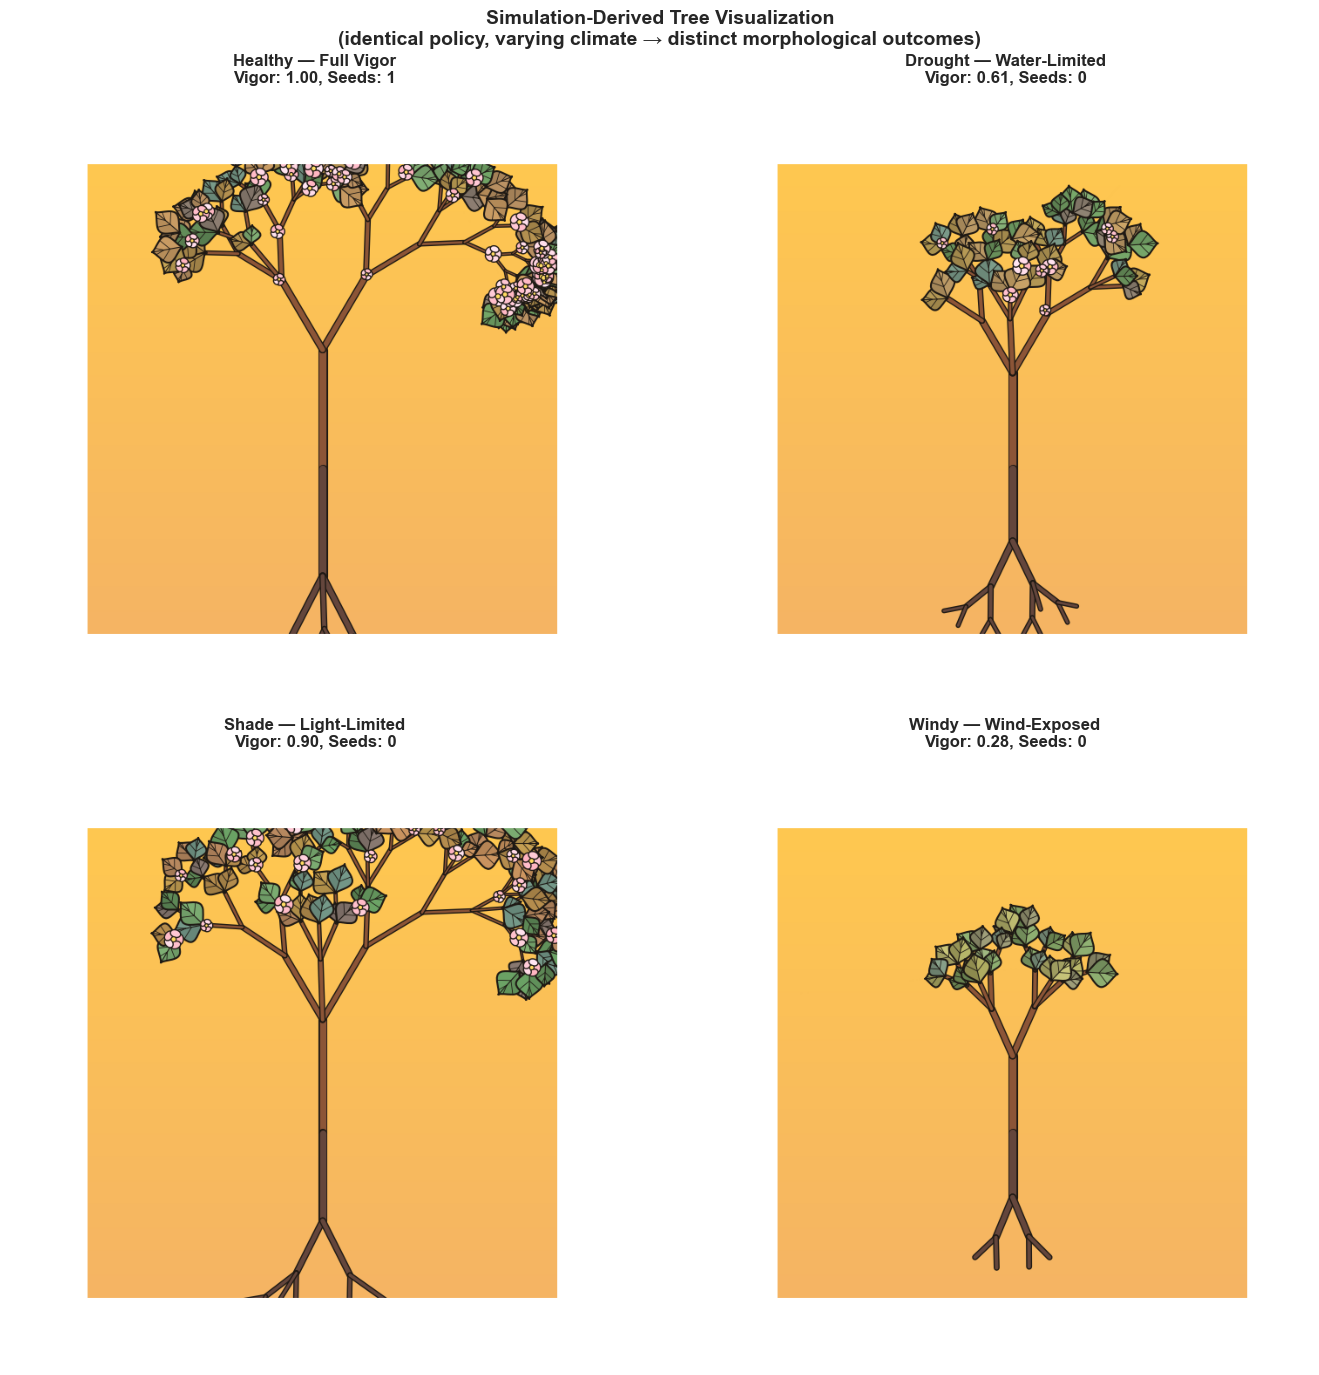

In [12]:
# Render trees for each climate scenario
fig, axes = plt.subplots(2, 2, figsize=(14, 14))

titles = {
    'healthy': 'Healthy — Full Vigor',
    'drought': 'Drought — Water-Limited',
    'shade': 'Shade — Light-Limited',
    'windy': 'Windy — Wind-Exposed',
}

for ax, (name, data) in zip(axes.flat, results.items()):
    # Render tree with stress-adjusted parameters
    fig_tree, ax_tree, stress = render_stressed_tree(
        data['trajectory'],
        data['climate'],
        seed=42,
        figsize=(7, 7),
    )
    
    # Copy the rendered content to our subplot
    fig_tree.canvas.draw()
    img = np.frombuffer(fig_tree.canvas.buffer_rgba(), dtype=np.uint8)
    img = img.reshape(fig_tree.canvas.get_width_height()[::-1] + (4,))
    
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f"{titles[name]}\nVigor: {stress.vigor:.2f}, Seeds: {float(data['trajectory'].seeds):.0f}", 
                fontsize=12, fontweight='bold')
    
    plt.close(fig_tree)

plt.suptitle('Simulation-Derived Tree Visualization\n'
             '(identical policy, varying climate → distinct morphological outcomes)',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

### How Stress Maps to Visual Parameters

The `stress_to_params()` and `stress_to_style()` functions translate simulation stress indicators
into visual tree parameters:

| Stress Type | Tree Form (params) | Visual Style (colors) |
|-------------|-------------------|----------------------|
| **Drought** | Sparser canopy, more early termination | Yellow/brown leaf palette |
| **Low Light** | Etiolated (longer, thinner branches) | Dark green palette |
| **High Wind** | Compact, tighter angles | Standard palette (form changes dominate) |
| **Low Vigor** | Smaller overall size, reduced depth | Muted colors |
| **Poor Leaf Health** | Fewer veins, darker panels | Darker panel shading |

In [13]:
# Show how stress transforms into tree parameters
print("STRESS → TREE PARAMETER MAPPINGS")
print("=" * 60)

base_params = TreeParams()
base_style = TreeStyle()

for name, data in results.items():
    stress = data['stress']
    params = stress_to_params(stress)
    style = stress_to_style(stress)
    
    print(f"\n{name.upper()}:")
    print(f"  Trunk length:    {base_params.trunk_length:.0f} → {params.trunk_length:.0f} "
          f"({'↓' if params.trunk_length < base_params.trunk_length else '↑'})")
    print(f"  Branch depth:    {base_params.depth} → {params.depth}")
    print(f"  Early stop prob: {base_params.early_stop:.2f} → {params.early_stop:.2f}")
    print(f"  Blossom density: {base_params.blossom_density:.2f} → {params.blossom_density:.2f}")
    print(f"  Leaf veins:      {base_style.n_veins} → {style.n_veins}")
    print(f"  First leaf color: {base_style.leaf_colors[0]} → {style.leaf_colors[0]}")

STRESS → TREE PARAMETER MAPPINGS

HEALTHY:
  Trunk length:    120 → 144 (↑)
  Branch depth:    5 → 5
  Early stop prob: 0.15 → 0.15
  Blossom density: 0.35 → 0.42
  Leaf veins:      4 → 2
  First leaf color: #b42840 → #c19767

DROUGHT:
  Trunk length:    120 → 116 (↓)
  Branch depth:    5 → 5
  Early stop prob: 0.15 → 0.27
  Blossom density: 0.35 → 0.15
  Leaf veins:      4 → 2
  First leaf color: #b42840 → #c3a06a

SHADE:
  Trunk length:    120 → 137 (↑)
  Branch depth:    5 → 5
  Early stop prob: 0.15 → 0.15
  Blossom density: 0.35 → 0.40
  Leaf veins:      4 → 2
  First leaf color: #b42840 → #c08f64

WINDY:
  Trunk length:    120 → 92 (↓)
  Branch depth:    5 → 4
  Early stop prob: 0.15 → 0.15
  Blossom density: 0.35 → 0.00
  Leaf veins:      4 → 2
  First leaf color: #b42840 → #c7c476
